### Atmospheric Point-Spread Function (PSF) convolutions in each slice can be very slow for large datacubes

Therefore want something that will parallelize the convolution operation. This next cell is just a check for the speed improvement that can be obtained by distributing the convolution tasks with 4 processes (2 cpus with hyperthreading). I also examine the results for a large PSF. There is considerable speed-up. Definitely worth doing. With this, I can submit a job-array in which each node handles a large number of datacubes and each datacube is handled very quickly with the worker cpus.

(20, 512, 512)
11.152171611785889
1.569823980331421
(20, 512, 512)
True
(20, 512, 512)


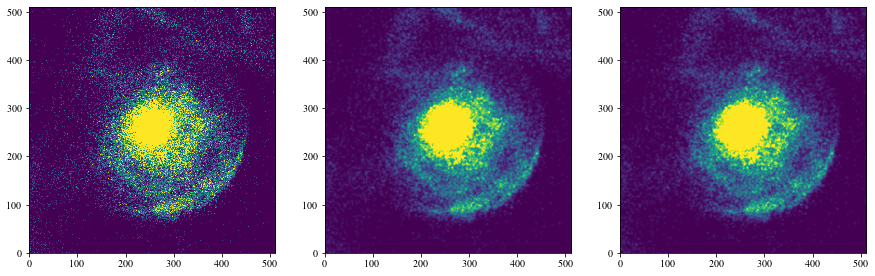

In [13]:
import os,sys,time
import multiprocessing
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import RealSim_IFS

def MyPool(fcn,args,nthreads=1):
    pool = multiprocessing.Pool(nthreads)
    out = pool.map(fcn,args)  
    pool.close()
    pool.join()
    del pool
    return out

def Convolve(args):
    data,kernel=args
    return convolve(data,kernel)

def MaNGA_Prepare(filename,redshift=0.046,psf_type='None',psf_fwhm_arcsec=10,
                 cosmo=FlatLambdaCDM(H0=70,Om0=0.3)):
    
    if not os.access(filename,0):
        sys.exit('Datacube not found. Quitting...')
    
    if filename.endswith('.fits'):
        data = fits.getdata(filename).transpose([2,0,1])[150-10:150+10]
        hdr = fits.getheader(filename)
    else:
        sys.exit('Datacube is not in FITS format. Quitting...')
        
    print(data.shape)
    # speed of light [m/s]
    speed_of_light = 2.99792458e8
    # kiloparsec per arcsecond scale
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    # luminosity distance in Mpc
    luminosity_distance = cosmo.luminosity_distance(z=redshift) # [Mpc]
        
    fov_size_kpc = hdr['FOVSIZE']/1000.
    kpc_per_pixel = fov_size_kpc/data.shape[0]
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec

    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    axarr[0].imshow(data[5],vmin=0,vmax=1e4,origin='lower')
    
    if psf_type is not 'None':
        valid_psf_types = ['Gaussian',]
        if psf_type in valid_psf_types:
            if psf_type == 'Gaussian':
                from astropy.convolution import Gaussian2DKernel
                std = psf_fwhm_arcsec/arcsec_per_pixel/2.355
                kernel = Gaussian2DKernel(x_stddev=std,y_stddev=std)   
                
                data_serial = np.zeros_like(data)
                start = time.time()
                for i in range(len(data_serial)):
                    data_serial[i] = convolve(data[i],kernel)
                print(time.time()-start)
                axarr[1].imshow(data_serial[5],vmin=0,vmax=1e4,origin='lower')
                
                data_parallel = np.zeros_like(data)
                cpu_count = multiprocessing.cpu_count()  
                start = time.time()
                data_parallel = np.array(MyPool(Convolve,[(data[i],kernel) for i in range(len(data))],cpu_count))
                print(time.time()-start)
                print(data_parallel.shape)
                axarr[2].imshow(data_parallel[5],vmin=0,vmax=1e4,origin='lower')
                
                print(np.all(data_serial==data_parallel))
                
    return data
        
    
    
if __name__ == '__main__':

    filename = '/Users/cbottrell/Project/RealSim-MaNGA/LOSVD/kinemetry_datacube_G2G3_e-orbit_1_0368_stars_i0.fits'
    data = MaNGA_Prepare(filename,psf_type='Gaussian')
    print(data.shape)
    
    
    

In [6]:
print(np.ones(3))

[1. 1. 1.]


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Running in serial
That took  0.5604321956634521  seconds
Running in parallel
Number of threads:  4
That took  0.4987208843231201  seconds
(10, 128, 128)


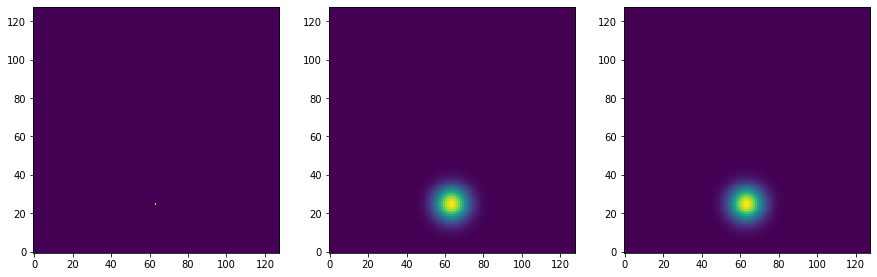

In [95]:
import multiprocessing
import numpy as np
import os,sys,time
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import matplotlib.pyplot as plt


def mypool(fcn,args,nthreads=1):
    pool = multiprocessing.Pool(nthreads)
    out = pool.map(fcn,args)  
    pool.close()
    pool.join()
    del pool
    return out


# the function that runs a bunch of calculations on 3 inputs.  (can extend to more if needed)
# this function returns two results
def myfunction(arg):
    data,kernel = arg
    data = convolve(data,kernel)
    return data
    
# I have ngal galaxies, and they all have different x,y,z values.  Here are my arrays that contain these data.
ngal = 10

data = np.zeros((128,128,ngal))
data[25,63,:]=1
data *= np.arange(ngal)

fig,axarr = plt.subplots(1,3,figsize=(15,5))
ax = axarr[0]
ax.imshow(data[:,:,1],origin='lower')

data = np.transpose(data,[2,0,1])
print(np.sum(data,axis=(1,2)))

std = 6
kernel = Gaussian2DKernel(x_stddev=std,y_stddev=std)


# run myfunction on the list in serial.  The print statement should print out x,y,z in order
print('Running in serial')
data_serial = np.zeros_like(data)
tstart = time.time()
for i in range(ngal): data_serial[i] = myfunction((data[i],kernel))
print('That took ',time.time()-tstart,' seconds')

ax = axarr[1]
ax.imshow(data_serial[1],origin='lower')

# run myfunction on the list in parallel.  Parallelization runs the nthreads in random order, so the print order should be random
print('Running in parallel')
nthreads = multiprocessing.cpu_count()
print('Number of threads: ',nthreads)
args = zip(data,[kernel]*len(data))
tstart = time.time()
data_parallel = np.asarray(mypool(myfunction,args,nthreads=nthreads))
print('That took ',time.time()-tstart,' seconds')
print(data_parallel.shape)

ax = axarr[2]
ax.imshow(data_parallel[1],origin='lower')


/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/cbottrell/anaconda3/envs/cfis/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero en

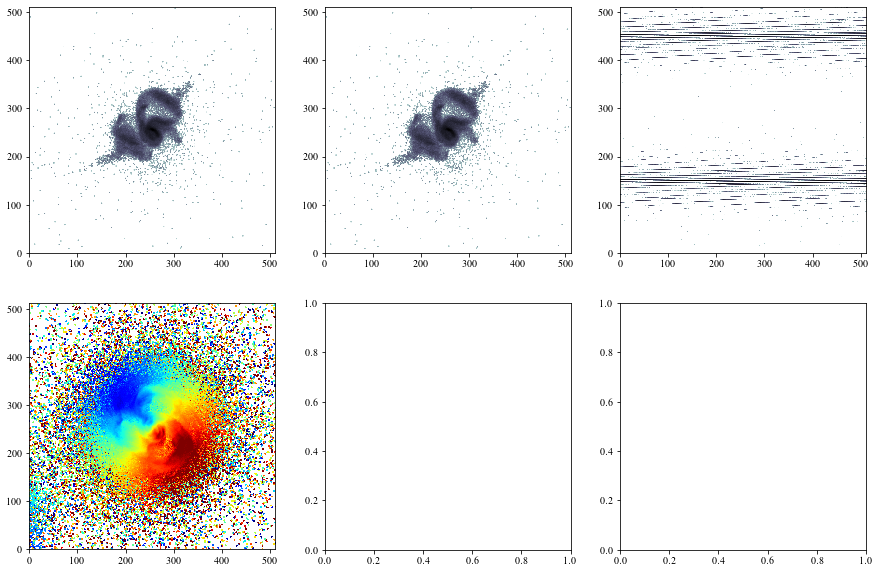

In [19]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os,sys,time

def generate_maps(losvd_name):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = fits.getdata(losvd_name)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps

filename = '/Users/cbottrell/Project/RealSim-MaNGA/LOSVD/kinemetry_datacube_G2G3_e-orbit_1_0037_stars_i0.fits'
maps = generate_maps(filename)
data = fits.getdata(filename)

fig,axarr = plt.subplots(2,3,figsize=(15,10))

axarr = axarr.flatten()

axarr[0].imshow(np.log10(data[...,150]),vmin=1,vmax=6,cmap='bone_r',origin='lower')

datat = np.transpose(data,[2,0,1])
axarr[1].imshow(np.log10(datat[150]),vmin=1,vmax=6,cmap='bone_r',origin='lower')

datar = data.reshape(-1,data.shape[0],data.shape[1])

axarr[2].imshow(np.log10(datar[150]),vmin=1,vmax=6,cmap='bone_r',origin='lower')

axarr[3].imshow(maps[1],vmin=-100,vmax=100,cmap='jet',origin='lower')


[<astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>, <astropy.convolution.kernels.Gaussian2DKernel object at 0x10dbe0940>]
10


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 36, 49, 64, 81, 25]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
54385
[54384, 54385, 54385, 54385]
We lacked patience and got a multiprocessing.TimeoutError
For the moment, the pool remains available for more work
Now the pool is closed and no longer available


## Generate MaNGA maps

In [6]:
import os,sys,time
import multiprocessing
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)


In [2]:

def Pool_Processes(fcn,args,processes=1):
    pool = multiprocessing.Pool(processes)
    out = pool.map(fcn,args)  
    pool.close()
    pool.join()
    del pool
    return out

def Convolve_Slice(args):
    data,kernel=args
    return convolve(data,kernel)

def Prepare_IFS(filename,redshift=0.046,psf_type='None',psf_fwhm_arcsec=1.5,
                cosmo=FlatLambdaCDM(H0=70,Om0=0.3)):
    
    if not os.access(filename,0):
        sys.exit('Datacube not found. Quitting...')
    
    if filename.endswith('.fits'):
        data = np.transpose(fits.getdata(filename),[2,0,1])
        hdr = fits.getheader(filename)
    else:
        sys.exit('Datacube is not in FITS format. Quitting...')
        
    # speed of light [m/s]
    speed_of_light = 2.99792458e8
    # kiloparsec per arcsecond scale
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    # luminosity distance in Mpc
    luminosity_distance = cosmo.luminosity_distance(z=redshift) # [Mpc]
        
    fov_size_kpc = hdr['FOVSIZE']/1000.
    kpc_per_pixel = fov_size_kpc/hdr['NAXIS2']
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
    
    if psf_type is not 'None':
        valid_psf_types = ['Gaussian',]
        
        if psf_type in valid_psf_types:
            
            if psf_type == 'Gaussian':
                from astropy.convolution import Gaussian2DKernel
                std = psf_fwhm_arcsec/arcsec_per_pixel/2.355
                kernel = Gaussian2DKernel(x_stddev=std,y_stddev=std)  
                
            if "SLURM_JOB_CPUS_PER_NODE" in os.environ:
                cpu_count = int(os.environ["SLURM_JOB_CPUS_PER_NODE"])
            else:
                cpu_count = multiprocessing.cpu_count()
            args = [(data[i],kernel) for i in range(len(data))]
            data = np.array(Pool_Processes(Convolve_Slice,args,cpu_count))
                
    return data
        
def Generate_Maps_From_File(losvd_name):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = fits.getdata(losvd_name)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps
    
def Generate_Maps_From_Data(losvd_name,losvd_data):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = losvd_data.transpose(1,2,0)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps    

    

In [ ]:
if __name__ == '__main__':
    
    fig,axarr = plt.subplots(1,2,figsize=(10,5))
    
    filename = '/home/bottrell/scratch/Fire_Kinematics/LOSVD/G2G3_e/orbit_1/kinemetry_datacube_G2G3_e-orbit_1_0149_stars_i1.fits'
    
    start = time.time()
    maps = Generate_Maps_From_File(filename)
    print('Time to generate maps from idealized LOSVD: {}'.format(time.time()-start))
    axarr[0].imshow(maps[1],vmin=-120,vmax=120,cmap='jet',origin='lower')
    
    start = time.time()
    data = Prepare_IFS(filename,psf_type='Gaussian')
    print('Time to convolve LOSVD with MaNGA PSF: {}'.format(time.time()-start))
    maps = Generate_Maps_From_Data(filename,data)
    axarr[1].imshow(maps[1],vmin=-120,vmax=120,cmap='jet',origin='lower')
    

In [3]:
if __name__ == '__main__':
    
    filename = '/home/bottrell/scratch/Fire_Kinematics/LOSVD/G2G3_e/orbit_1/kinemetry_datacube_G2G3_e-orbit_1_0149_stars_i1.fits'
    
    data = Prepare_IFS(filename,psf_type='Gaussian',psf_fwhm_arcsec=1.5)
    

    

In [1]:
import os,sys,time
import multiprocessing
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import RealSim_IFS


In [16]:
(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='None',fibers_per_side=1,n_observations=1,
                                           bundle_xoffset_arcsec=0.,
                                           bundle_yoffset_arcsec=0.,
                                           rotation_degrees = 0.,
                                           return_params=True)
fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = xc_arr.shape[-1]

filename = '/home/bottrell/scratch/Fire_Kinematics/LOSVD/G2G3_e/orbit_1/kinemetry_datacube_G2G3_e-orbit_1_0149_stars_i1.fits'
data = fits.getdata(filename).transpose(2,0,1)
hdr = fits.getheader(filename)

In [1]:
import os,sys,time
import numpy as np
import RealSim_IFS
from glob import glob
from shutil import copy as cp
import matplotlib.pyplot as plt

if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
    wdir = os.environ['SLURM_TMPDIR']
    os.chdir(wdir)
    print(os.getcwd())

/localscratch/bottrell.34026249.0


5.212025880813599
5.353434324264526
5.262359142303467
5.203747749328613
4.969932794570923


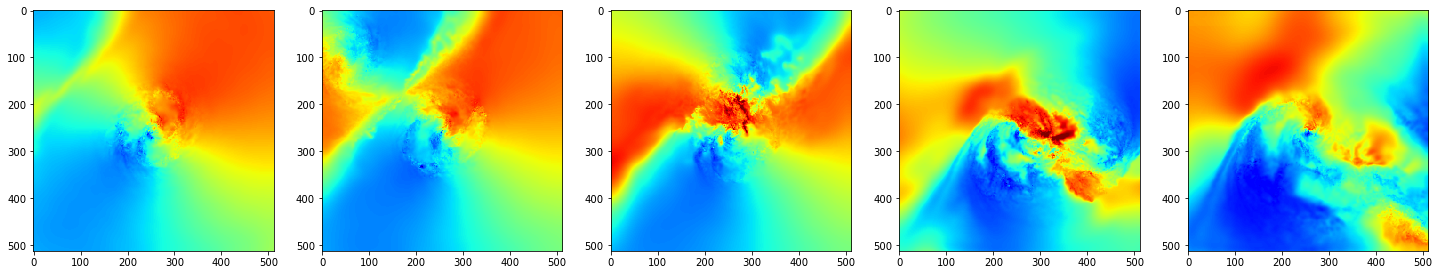

In [4]:
losvd_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD/G2G3_e/orbit_1'
filenames = list(sorted(glob(losvd_dir+'/*_gas_i0.fits')))[:5]

fig,axarr = plt.subplots(1,5,figsize=(25,5))

for filename,ax in zip(filenames,axarr.flat):
    localfile = filename.replace(losvd_dir,wdir)
    start = time.time()
    cp(filename,localfile)
    maps = RealSim_IFS.Generate_Maps_From_File(localfile)
    print(time.time()-start)
    ax.imshow(maps[1],vmin=-150,vmax=150,cmap='jet')
    if os.access(localfile,0):os.remove(localfile)

